# Course 4 - Project - Part 4: Simple decision trees

<a name="top-4"></a>
This notebook is concerned with *Part 4: Simple decision trees*.

**Contents:**
* [Step 0: Loading data](#step-4.0)
* [Step 1: Fit a decision tree classifier of depth 3](#step-4.1)
* [Step 2: Plot the corresponding decision tree](#step-4.2)
* [Step 3: Try to reduce the number of dimensions with PCA first](#step-4.3)
* [Step 4: Summary](#step-4.4)

## Step 0: Loading data<a name="step-4.0"></a> ([top](#top-4))
---

We load the training set with the extracted high-level features.

In [1]:
# Standard library.
import os
import pathlib
import typing as T

# 3rd party.
import numpy as np

# Project.
import utils

In [2]:
separator = ''.center(80, '-')

path_train = pathlib.Path.cwd() / 'data' / 'swissroads-features-train.npz'
data_train = utils.load(path_train)
print(separator)
print(f'Dataset: train\n{utils.info(data_train)}')

path_valid = pathlib.Path.cwd() / 'data' / 'swissroads-features-valid.npz'
data_valid = utils.load(path_valid)
print(separator)
print(f'Dataset: valid\n{utils.info(data_valid)}')

path_test = pathlib.Path.cwd() / 'data' / 'swissroads-features-test.npz'
data_test = utils.load(path_test)
print(separator)
print(f'Dataset: test\n{utils.info(data_test)}')

--------------------------------------------------------------------------------
Dataset: train
data: shape=(280, 224, 224, 3), dtype=float32
labels: shape=(280,), dtype=int64
names: shape=(6,), dtype=<U10
features: shape=(280, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: valid
data: shape=(139, 224, 224, 3), dtype=float32
labels: shape=(139,), dtype=int64
names: shape=(6,), dtype=<U10
features: shape=(139, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: test
data: shape=(50, 224, 224, 3), dtype=float32
labels: shape=(50,), dtype=int64
names: shape=(6,), dtype=<U10
features: shape=(50, 1280), dtype=float32


In [3]:
names = data_train['names']  # Same for all data sets.
assert (
    np.all(data_train['names'] == data_valid['names']) and
    np.all(data_train['names'] == data_test['names'])
)

X_train = data_train['data']
y_train = data_train['labels']
F_train = data_train['features']

X_valid = data_valid['data']
y_valid = data_valid['labels']
F_valid = data_valid['features']

X_test = data_test['data']
y_test = data_test['labels']
F_test = data_test['features']

## Step 1: Fit a decision tree classifier of depth 3<a name="step-4.1"></a> ([top](#top-4))
---

In [4]:
# 3rd party.
%matplotlib inline
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

We fit a decision tree classifier of depth 3.

In [5]:
# Create decision tree.
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=3,
    random_state=0  # Make it deterministic.
)

# Fit decision tree.
dt.fit(F_train, y_train)

# Get score on the training set.
accuracy_train = dt.score(F_train, y_train)
print(f'Train accuracy: {accuracy_train * 100:.1f} %')

# Get score on the test set.
accuracy_test = dt.score(F_test, y_test)
print(f'Test accuracy: {accuracy_test * 100:.1f} %')

Train accuracy: 75.4 %
Test accuracy: 72.0 %


## Step 2: Plot the corresponding decision tree<a name="step-4.2"></a> ([top](#top-4))
---

In [6]:
# 3rd party.
from sklearn.tree import export_graphviz

We plot the coresponding decision tree. In this case, since we are working with high-level features, we do not have better names for the features or the classes.

**Note:** In Sklearn 0.21+ the function `sklearn.tree.plot_tree` would offer more control to plot the tree.

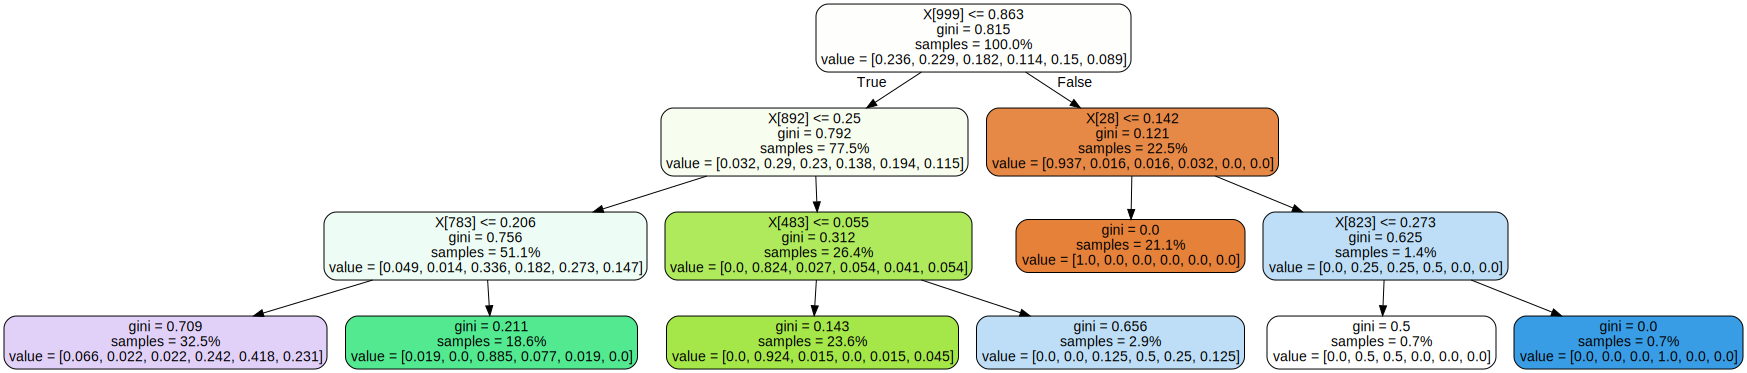

In [7]:
# Export the decision tree in dot format.
dot_data = export_graphviz(
    dt, out_file=None, filled=True, rounded=True, proportion=True   
)

# Render it.
graphviz.Source(dot_data)

## Step 3: Try to reduce the number of dimensions with PCA first<a name="step-4.3"></a> ([top](#top-4))
---

In [8]:
# 3rd party.
import pandas as pd
from matplotlib import ticker
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

We create a pipeline comprised of an optional scaler and a decision tree classifier.

In [9]:
scaler = StandardScaler()

pca = PCA(
    random_state=0  # Make it deterministic.
)

dt = DecisionTreeClassifier(
    criterion='gini',
    random_state=0  # Make it deterministic.
)

# Create the pipeline.
dt_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('dt', dt)
])

We perform a grid search.

In [10]:
max_depths = list(range(1, 10 + 1))  # 1, 2, ..., 10
n_components_s = [2, 3, 7, 14, 25, 41, 63, 96, 150, 280]  # See Part 2.

# Define the grid of values to search.
grid = ParameterGrid({
    'pca__n_components': n_components_s,
    'dt__max_depth': max_depths
})

In [11]:
gs_results = []

for params_dict in grid:
    # Set the parameters.
    dt_pipe.set_params(**params_dict)
    
    # Fit the clasifier to the data.
    dt_pipe.fit(F_train, y_train)
    
    # Store the scores.
    gs_result = params_dict
    gs_result['train_accuracy'] = dt_pipe.score(F_train, y_train)
    gs_result['valid_accuracy'] = dt_pipe.score(F_valid, y_valid)
    
    # Save result.
    gs_results.append(gs_result)

We convert the results to a data frame.

In [12]:
# Convert results to a data frame.
df_results = (pd
              .DataFrame(gs_results)
              .sort_values(by='valid_accuracy', ascending=False)
             )
df_results.head()

,dt__max_depth,pca__n_components,train_accuracy,valid_accuracy
44,5,25,0.964286,0.892086
82,9,7,1.000000,0.884892
92,10,7,1.000000,0.884892
64,7,25,0.996429,0.884892
62,7,7,0.985714,0.884892


We define a helper function to plot the validation curves.

In [13]:
def plot_validation_curves(df_results: pd.DataFrame, x_key: str, x_label: str) -> None:
    """\
    Plots the validation curves.
    
    Args:
        df_results: A data frame with the results of the grid search to display.
        x_key: The column that contains the values to use for the x-axis. Assumed to have an integer type.
        x_label: The label to use for the x-axis.
    """
    # Make sure the records are sorted by k in ascending order.
    df_results = df_results.sort_values(by=x_key)
    
    # Create a figure.
    fig, ax = plt.subplots()
    
    # Plot validation curves.
    ax.plot(df_results[x_key], df_results['train_accuracy'], label='training curve')
    ax.plot(df_results[x_key], df_results['valid_accuracy'], label='validation curve')
    
    # Add labels.
    ax.set_xlabel(x_label)
    ax.set_ylabel('accuracy')
    
    # Change the x-axis tick locator.
    ax.get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))

    # Add a marker for the best score.
    idx_best = df_results['valid_accuracy'].idxmax()
    x_best, valid_accuracy = df_results.loc[idx_best, [x_key, 'valid_accuracy']]
    # The series that represents the row may have a wider type.
    x_best = int(x_best)
    ax.scatter(x_best, valid_accuracy, marker='x', c='red', zorder=10)

    # Add a legend and a title.
    ax.legend()
    ax.set_title(f'Best value: {x_best} with {valid_accuracy * 100:.1f} % valid accuracy')

    plt.show()

### Best model of depth 3

We extract the results for a maximum depth of 3.

In [15]:
df_results_md3 = df_results[df_results['dt__max_depth'] == 3]

# We get the best result.
idx_best_md3 = df_results_md3['valid_accuracy'].idxmax()

# We gather the best parameters.
keys = ['pca__n_components', 'dt__max_depth']
params_best_md3 = {
    key: df_results_md3.loc[idx_best_md3, key] for key in keys
}

We plot the validation curves.

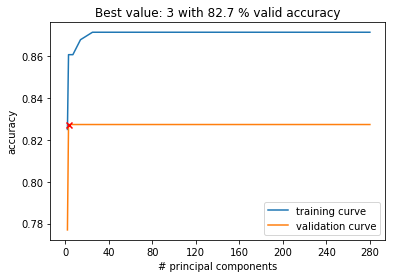

In [17]:
plot_validation_curves(df_results_md3, 'pca__n_components', '# principal components')

We evaluate the accuracy of the best model on the test set.

In [18]:
# Initialize and fit.
dt_pipe.set_params(**params_best_md3)
dt_pipe.fit(F_train, y_train)

# Evaluate on the test set.
test_accuracy = dt_pipe.score(F_test, y_test)
max_depth_best = params_best_md3['dt__max_depth']
print(f'Best max-depth: {max_depth_best} with {test_accuracy * 100:.1f} % test accuracy')

Best max-depth: 3 with 78.0 % test accuracy


**Comment:** With a maximum depth of 3, it seems that we cannot do better than 82.7 % of accuracy on the validation set and 78.0 % on the test set.

### Best model of any depth

We find the number of principal components that leads to the best accuracy on the validation set.

In [19]:
# We get the best result.
idx_best = df_results['valid_accuracy'].idxmax()

# We extract the results for the given number of principal components.
df_results_best = utils.filter_like(
    df_results, idx_best, ['pca__n_components'])

# We gather the best parameters.
keys = ['pca__n_components', 'dt__max_depth']
params_best = {
    key: df_results.loc[idx_best, key] for key in keys
}

We print the best parameters as well as the validation curves.

Best params:


{'pca__n_components': 25, 'dt__max_depth': 5}

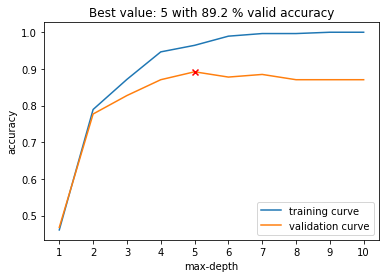

In [20]:
print(f'Best params:')
display(params_best)

# Plot the validation curves.
plot_validation_curves(df_results_best, 'dt__max_depth', 'max-depth')

We evaluate the accuracy of the best model on the test set.

In [21]:
# Initialize and fit.
dt_pipe.set_params(**params_best)
dt_pipe.fit(F_train, y_train)

# Evaluate on the test set.
test_accuracy = dt_pipe.score(F_test, y_test)
max_depth_best = params_best['dt__max_depth']
print(f'Best max-depth: {max_depth_best} with {test_accuracy * 100:.1f} % test accuracy')

Best max-depth: 5 with 80.0 % test accuracy


## Step 4: Summary<a name="step-4.4"></a> ([top](#top-4))
---

Here is a manual summary of the results:

| Model | Valid accuracy % | Test accuracy % |
|-------|------------------|-----------------|
| Decision tree | 75.4 | 72.0 |
| PCA (nc=3) + Decision tree (md=3) | 82.7 | 78.0 |
| PCA (nc=25) + Decision tree (md=5) | 89.2 | 80.0 |

Where:
* PCA: _nc_ = number of principal components
* Decision tree: _md_ = maximum depth

**Comment:** We do get better results if we reduce the number of dimensions with PCA first.